# SI618 Project
### Analyzing the Impact of Various Factors on B&B Visitor's Reviews 
#### — A study based on Airbnb datasets

Team members: Qian Dong (dqq) section 001; Yujun Zhang (yukiz) section 001; Yinuo Wei (seesaway) section 001


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap

### Cleaning and manipulation
#### 1. Primary dataset description:

This dataset contains essential details enabling an in-depth analysis of hosts, geographical availability, and key metrics required for predictions and drawing meaningful conclusions. It contains information about the name, host, location, room type, number of reviews, and the price of the house.

In [2]:
ab=pd.read_csv('data/AB_NYC_2019.csv')

In [3]:
ab.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [4]:
ab.shape

(48895, 16)

In [5]:
ab.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

In [6]:
ab.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


No incorrect data is found.

For numeric data:

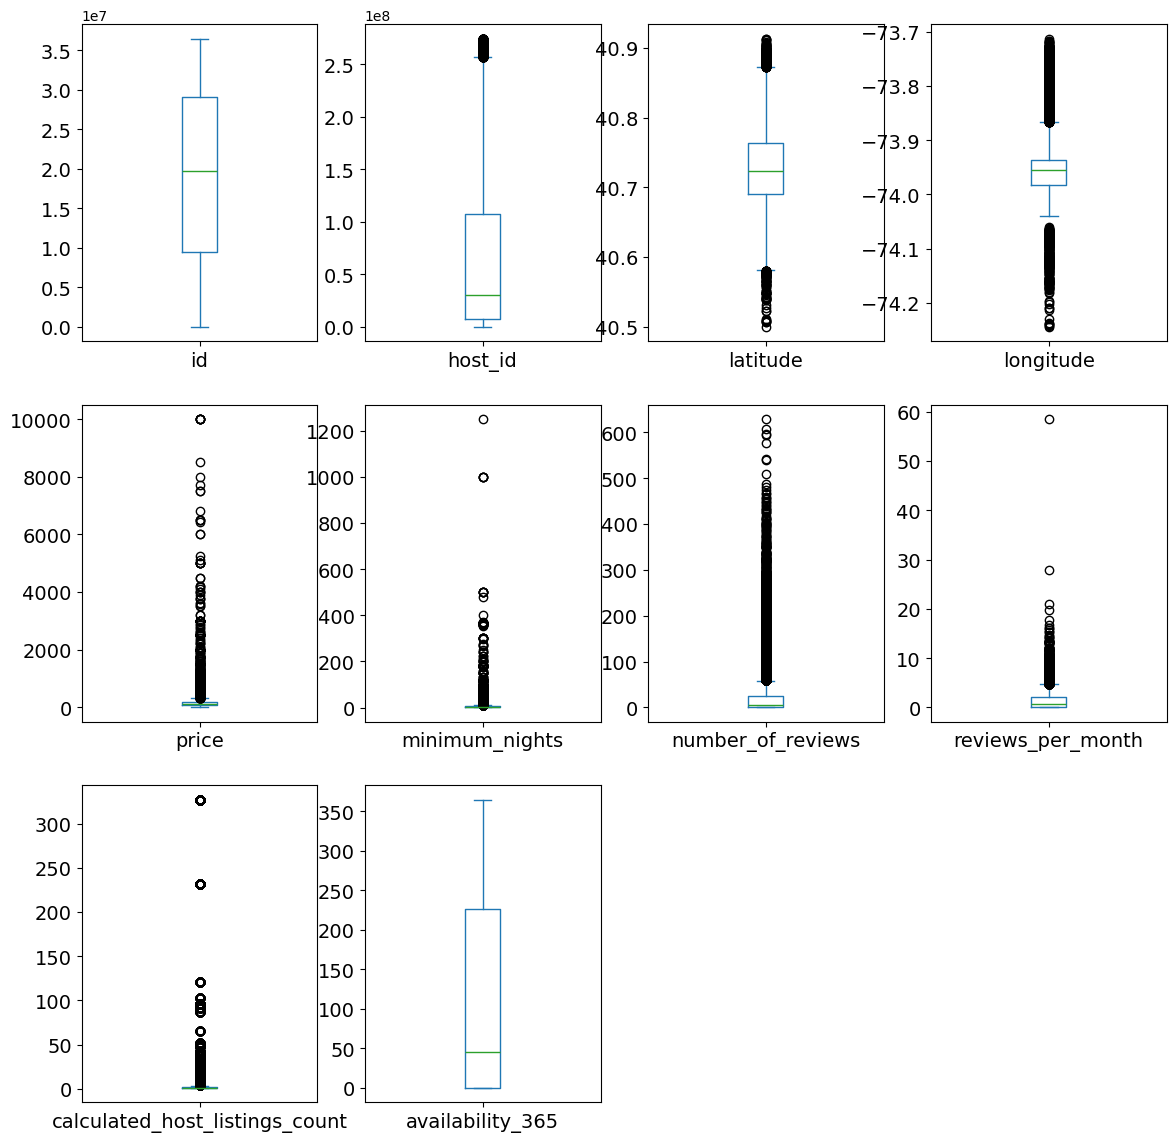

In [7]:
ab.select_dtypes(exclude=['object'])\
    .plot(kind='box', subplots=True, layout=(3,4), figsize=(14,14), fontsize=14)
plt.title('Box Plot for each input variable')
plt.show()

In [69]:
import warnings
warnings.filterwarnings('ignore')

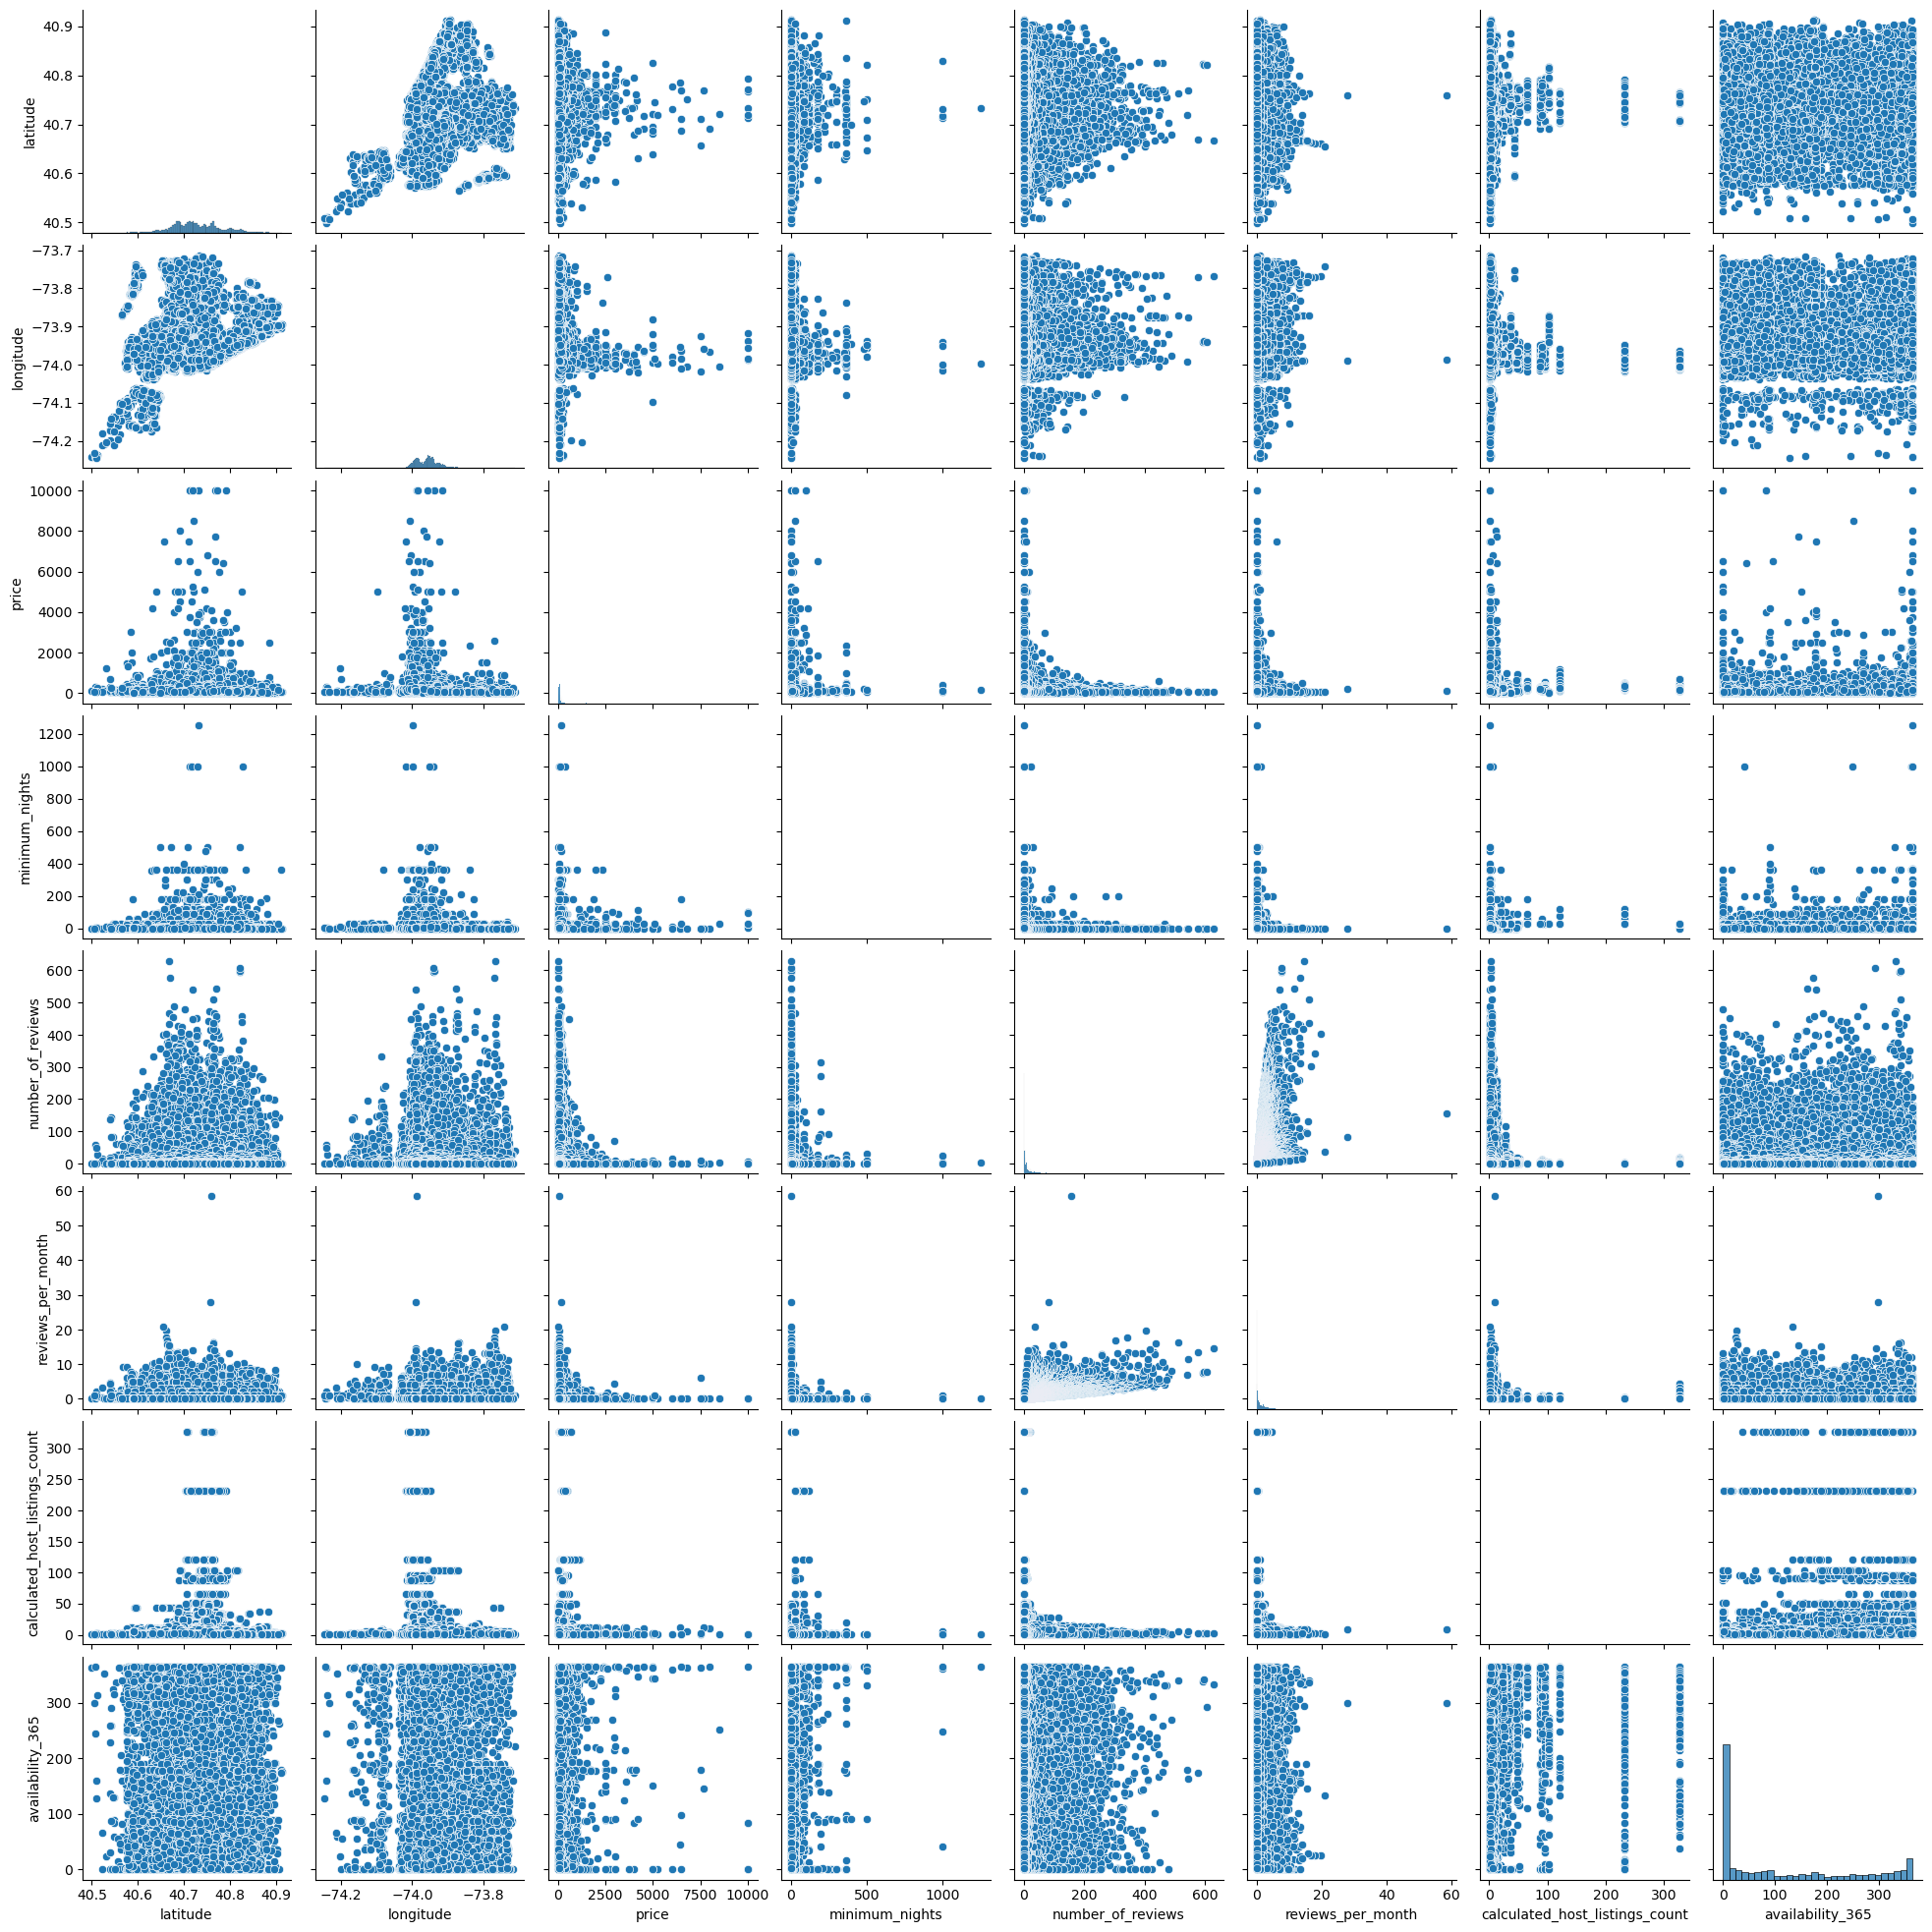

In [71]:
sns.pairplot(ab.select_dtypes(exclude=['object']).drop(['id','host_id'], axis=1))

From the summary of the table, there are some outliers of prices, so in the consideration of the plot layout, the price data is limited to those less than 2,000.

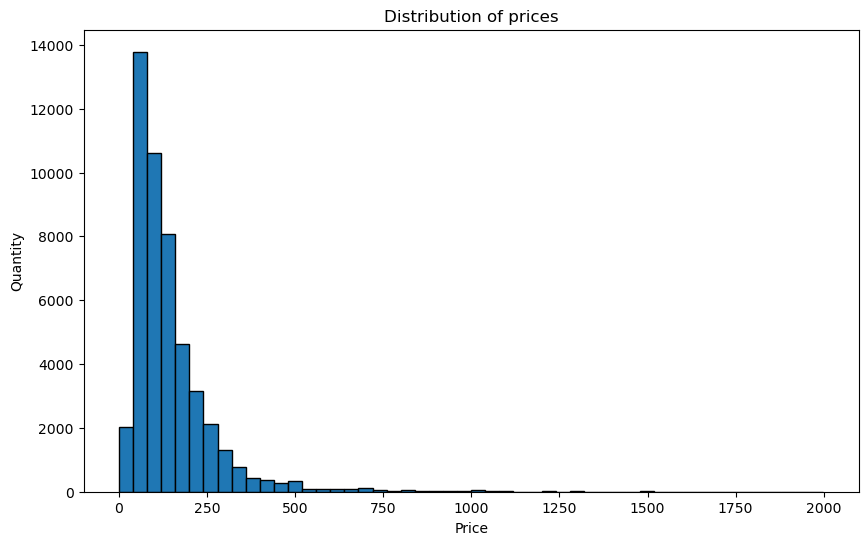

In [8]:
price_data = ab[ab.price < 2000].loc[:, ['id', 'price']]

plt.figure(figsize=(10, 6))
plt.hist(price_data.price, bins=50, ec='black')
plt.xlabel('Price')
plt.ylabel('Quantity')
plt.title('Distribution of prices')
plt.show()

From the plot, most of the price of houses and apartments are less than 500. Prices around 100 are the most common. In general, the number of houses and apartments available decreases as the price increases.

In [9]:
ab.select_dtypes(exclude=['object']).isna().sum()

id                                    0
host_id                               0
latitude                              0
longitude                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

Only review_per_month has missing values, so we only need to fill out the missing review_per_month values.

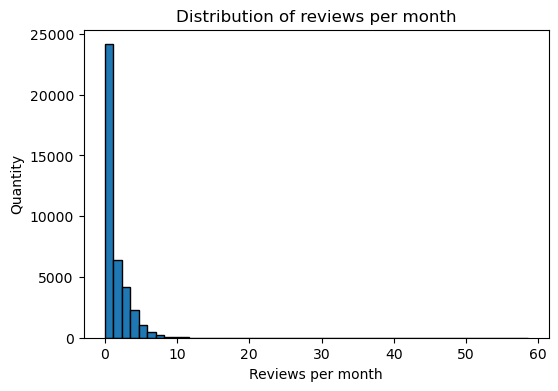

In [10]:
reviews_per_month_data = ab[ab.reviews_per_month.notna()].loc[:, ['id', 'reviews_per_month']]

plt.figure(figsize=(6, 4))
plt.hist(reviews_per_month_data.reviews_per_month, bins=50, ec='black')
plt.xlabel('Reviews per month')
plt.ylabel('Quantity')
plt.title('Distribution of reviews per month')
plt.show()

In [11]:
ab['reviews_per_month'].min()

0.01

From the hist plot of review_per_month and the min value of it, we can infer that the missing value should be 0. There should be no reviews if the review_per_month equals 0.

In [12]:
#replace missing with mode
ab['reviews_per_month'].fillna(0, inplace=True)

The updated graph:

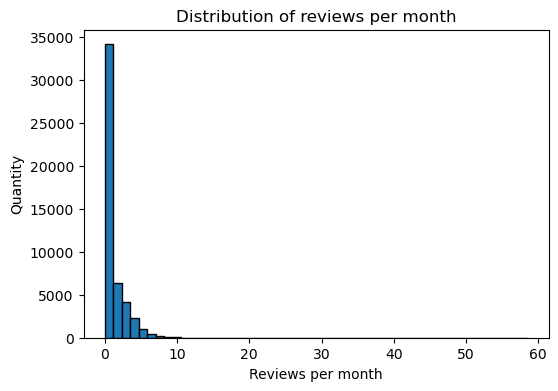

In [72]:
reviews_per_month_data = ab[ab.reviews_per_month.notna()].loc[:, ['id', 'reviews_per_month']]

plt.figure(figsize=(6, 4))
plt.hist(reviews_per_month_data.reviews_per_month, bins=50, ec='black')
plt.xlabel('Reviews per month')
plt.ylabel('Quantity')
plt.title('Distribution of reviews per month')
plt.show()

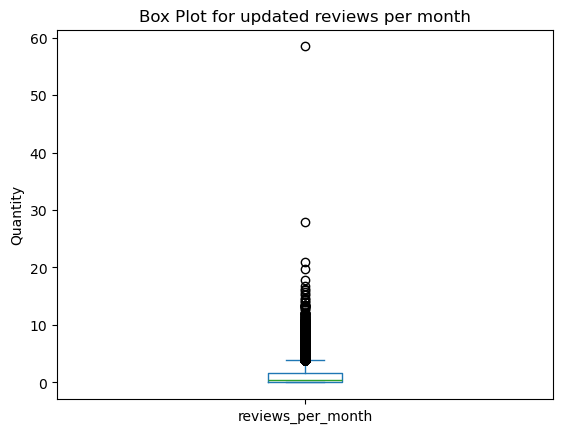

In [13]:
ab['reviews_per_month'].plot(kind='box')
plt.title('Box Plot for updated reviews per month')
plt.ylabel('Quantity')
plt.show()

For non-numeric data:

In [14]:
ab.select_dtypes(include=['object']).head()

,name,host_name,neighbourhood_group,neighbourhood,room_type,last_review
0,Clean & quiet apt home by the park,John,Brooklyn,Kensington,Private room,2018-10-19
1,Skylit Midtown Castle,Jennifer,Manhattan,Midtown,Entire home/apt,2019-05-21
2,THE VILLAGE OF HARLEM....NEW YORK !,Elisabeth,Manhattan,Harlem,Private room,NaN
3,Cozy Entire Floor of Brownstone,LisaRoxanne,Brooklyn,Clinton Hill,Entire home/apt,2019-07-05
4,Entire Apt: Spacious Studio/Loft by central park,Laura,Manhattan,East Harlem,Entire home/apt,2018-11-19


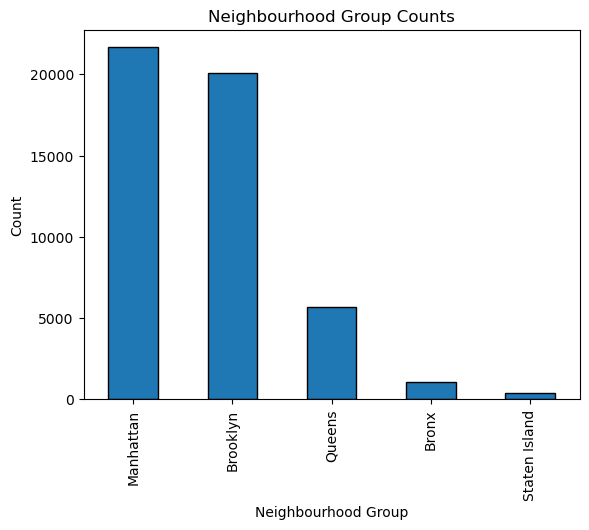

In [15]:
ab['neighbourhood_group'].value_counts().plot(kind='bar', edgecolor='black')
plt.title('Neighbourhood Group Counts')
plt.xlabel('Neighbourhood Group')
plt.ylabel('Count')
plt.show()

From the box plot of prices across difference neighbourhood groups, we can see the house prices in Manhattan is higher than the other neighbourhood groups, which means neighbourhood, or to say areas, cast an influence of the house price.
Also looking from the value count plot of houses or apartments in different neighbourhood groups, houses in Manhattan seems the most popular.

In [17]:
ab['neighbourhood'].nunique()

221

In [18]:
ab['neighbourhood'].value_counts().head(10)

neighbourhood
Williamsburg          3920
Bedford-Stuyvesant    3714
Harlem                2658
Bushwick              2465
Upper West Side       1971
Hell's Kitchen        1958
East Village          1853
Upper East Side       1798
Crown Heights         1564
Midtown               1545
Name: count, dtype: int64

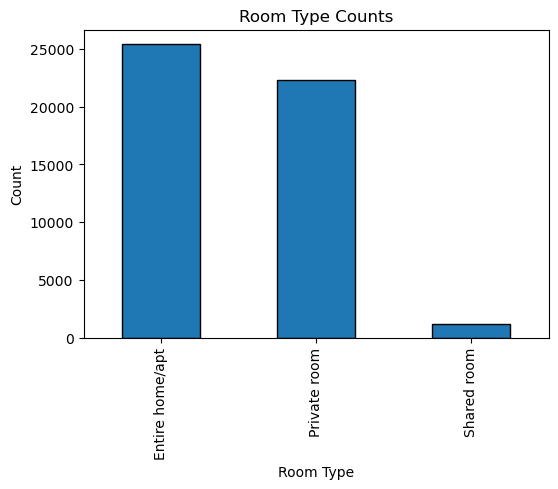

In [19]:
plt.figure(figsize=(6, 4))
ab['room_type'].value_counts().plot(kind='bar', edgecolor='black')
plt.title('Room Type Counts')
plt.xlabel('Room Type')
plt.ylabel('Count')
plt.show()

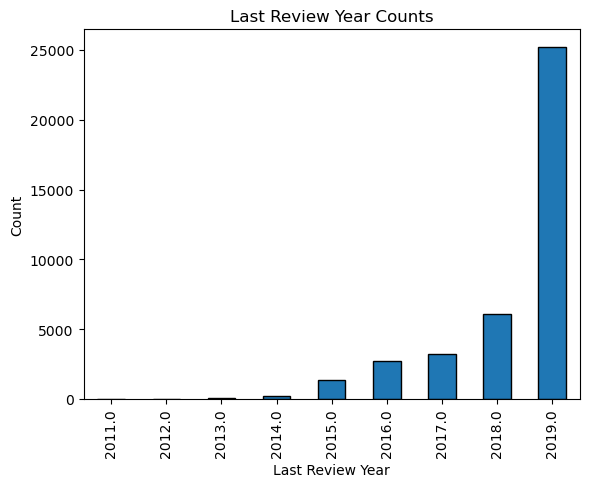

In [20]:
ab['last_review']=pd.to_datetime(ab['last_review'])
ab['last_review'].dt.year.value_counts().sort_index().plot(kind='bar', edgecolor='black')
plt.title('Last Review Year Counts')
plt.xlabel('Last Review Year')
plt.ylabel('Count')
plt.show()

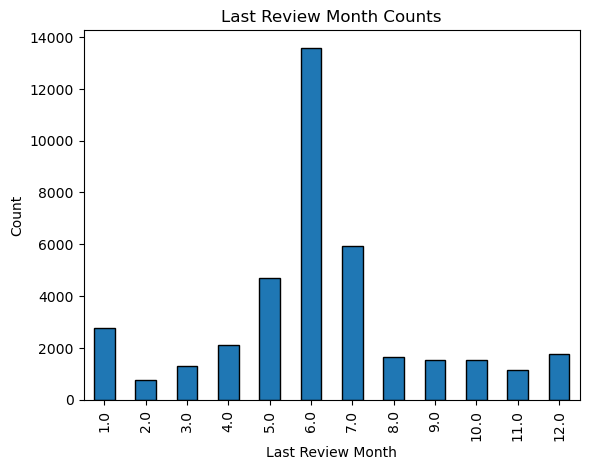

In [21]:
ab['last_review'].dt.month.value_counts().sort_index().plot(kind='bar', edgecolor='black')
plt.title('Last Review Month Counts')
plt.xlabel('Last Review Month')
plt.ylabel('Count')
plt.show()

In [22]:
# last and first review
ab['last_review'].max(), ab['last_review'].min()

(Timestamp('2019-07-08 00:00:00'), Timestamp('2011-03-28 00:00:00'))

In [23]:
ab['last_review'].value_counts().head(10)

last_review
2019-06-23    1413
2019-07-01    1359
2019-06-30    1341
2019-06-24     875
2019-07-07     718
2019-07-02     658
2019-06-22     655
2019-06-16     601
2019-07-05     580
2019-07-06     565
Name: count, dtype: int64

In [24]:
ab.select_dtypes(exclude=['number']).isna().sum()

name                      16
host_name                 21
neighbourhood_group        0
neighbourhood              0
room_type                  0
last_review            10052
dtype: int64

Missing names are not meaningful to fill. Only missing last_review can be filled. The missing value is corresponding to the missing value of review_per_month. So we should keep the missing values as null because it has the meaning of having no review.

In [25]:
ab[ab['last_review'].isna()][['number_of_reviews', 'last_review', 'reviews_per_month']].sample(5)

,number_of_reviews,last_review,reviews_per_month
25404,0,NaT,0.0
41630,0,NaT,0.0
48839,0,NaT,0.0
46537,0,NaT,0.0
48792,0,NaT,0.0


In [26]:
ab[ab['last_review'].isna()][['number_of_reviews', 'last_review', 'reviews_per_month']].nunique()

number_of_reviews    1
last_review          0
reviews_per_month    1
dtype: int64

It turns out that missing values of review related data are all because reviews do not exit.

2. Secondary dataset description

This dataset encompasses user feedback on Airbnb listings in New York City, offering
valuable insights into the firsthand experiences of staying in these accommodations. By
perusing these reviews, one can gain an understanding of the strengths, weaknesses, and
the ideal demographic for each listing. It contains the time that the reviews were posted and
the content of the reviews.

In [27]:
reviews=pd.read_csv('data/AB_reviews_NYC.csv')

In [28]:
reviews.head()

,listing_id,url,review_posted_date,review
0,2595,https://www.airbnb.com/rooms/2595,November 2019,"Great location, convenient to everything. Very..."
1,2595,https://www.airbnb.com/rooms/2595,May 2019,Place was so cute and comfy! Host was great an...
2,2595,https://www.airbnb.com/rooms/2595,May 2019,10 / 10 would stay again
3,2595,https://www.airbnb.com/rooms/2595,January 2019,The apartment met expectations to how it was i...
4,2595,https://www.airbnb.com/rooms/2595,December 2018,Great space in a fun old building in NYC. Love...


In [29]:
reviews.shape

(17444, 4)

In [30]:
reviews.isna().sum()

listing_id            0
url                   0
review_posted_date    0
review                0
dtype: int64

There's no missing values

In [31]:
reviews['listing_id'].nunique()

219

In [32]:
reviews['url'].nunique()

219

url and listing_id number is corresponded. url is not needed for data analysis.

In [33]:
reviews.drop(columns=['url'], inplace=True)

/var/folders/md/8wvl5f453sj4wkpghh7cbfg40000gn/T/ipykernel_47271/1203550088.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  reviews['review_posted_date']=pd.to_datetime(reviews['review_posted_date'])


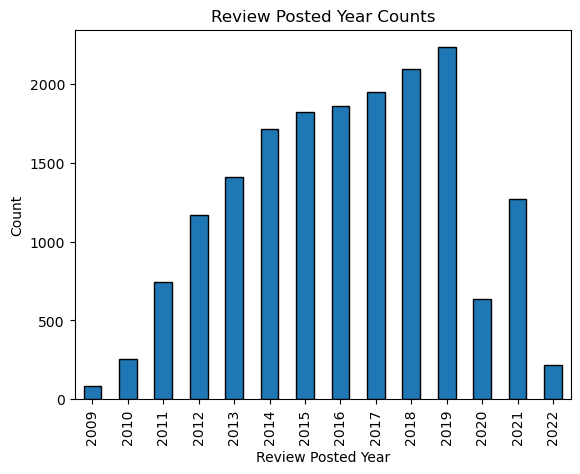

In [34]:
#revert review_posted_date into datatime
reviews['review_posted_date']=pd.to_datetime(reviews['review_posted_date'])
#plot review_posted_date
reviews['review_posted_date'].dt.year.value_counts().sort_index().plot(kind='bar', edgecolor='black')
plt.title('Review Posted Year Counts')
plt.xlabel('Review Posted Year')
plt.ylabel('Count')
plt.show()

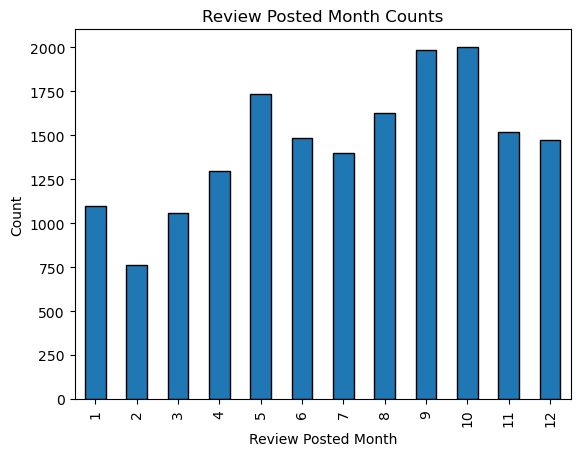

In [35]:
reviews['review_posted_date'].dt.month.value_counts().sort_index().plot(kind='bar', edgecolor='black')
plt.title('Review Posted Month Counts')
plt.xlabel('Review Posted Month')
plt.ylabel('Count')
plt.show()

<Axes: ylabel='Frequency'>

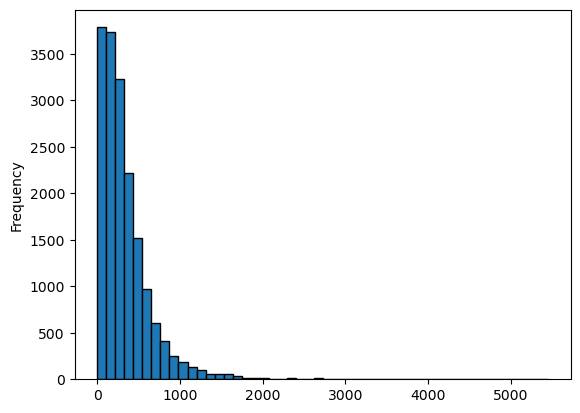

In [36]:
#plot histgram of review length
reviews['review'].str.len().plot(kind='hist', bins=50, edgecolor='black')

Most of the reviews are short.

### Visualization of features correlations

/Users/dqq/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/dqq/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/dqq/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


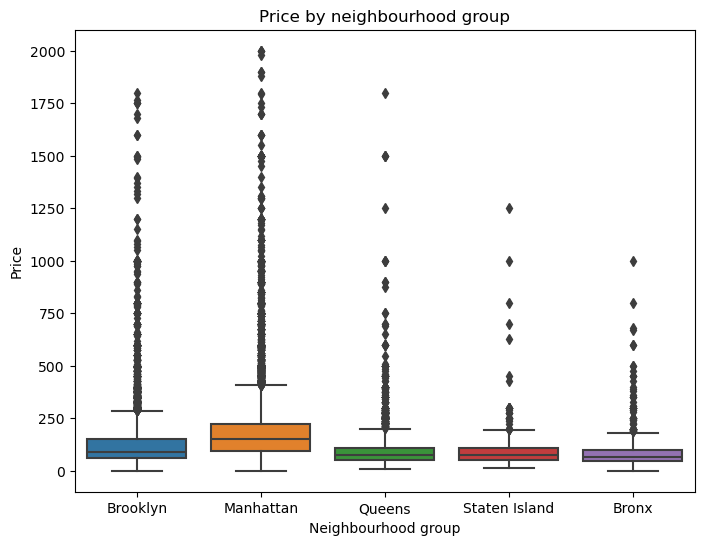

In [ ]:
# box plot of price by neighbourhood_group
plt.figure(figsize=(8, 6))
sns.boxplot(x='neighbourhood_group', y='price', data=ab[ab.price < 2000])
plt.xlabel('Neighbourhood group')
plt.ylabel('Price')
plt.title('Price by neighbourhood group')
plt.show()

1. Heatmap of Correlations of the Primary dataset

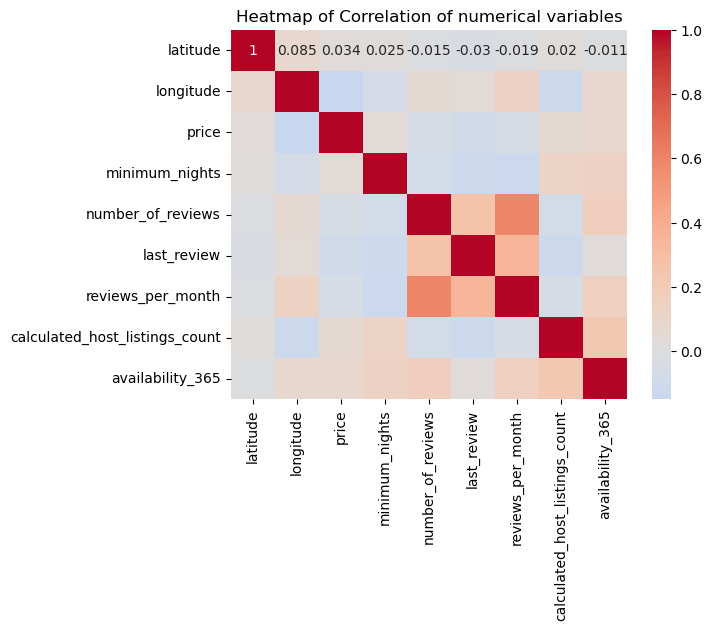

In [37]:
sns.heatmap(ab.select_dtypes(exclude=['object']).drop(['id', 'host_id'], axis=1)
            .corr(), cmap='coolwarm', center=0, annot=True)
plt.title('Heatmap of Correlation of numerical variables')
plt.show()

The positive relation of review related data is of no doubt. Longitude also affect price and host listing negatively and review_per_month positively, which is a geographic influence. Mininum night and review per month has logical negative influence. availability_365 has positive affect on review numbers. host listing number  has negative effect on review numebrs. More host_listing and more availability of year is related.

### Heatmap of Geometric Distribution of Number of Rooms

In [38]:
m = folium.Map(location=[ab['latitude'].mean(), ab['longitude'].mean()], zoom_start=12)
HeatMap(data=ab[['latitude', 'longitude']], radius=15).add_to(m)
m

In the map generated, red and orange areas represent areas with more houses or apartment for reservation.

### Joining Datasets


In [39]:
airbnb = pd.merge(ab, reviews, left_on='id', right_on='listing_id', how='inner')
airbnb.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,listing_id,review_posted_date,review
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355,2595,2019-11-01,"Great location, convenient to everything. Very..."
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355,2595,2019-05-01,Place was so cute and comfy! Host was great an...
2,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355,2595,2019-05-01,10 / 10 would stay again
3,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355,2595,2019-01-01,The apartment met expectations to how it was i...
4,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355,2595,2018-12-01,Great space in a fun old building in NYC. Love...


### Machine Learning (Predict Price)

In this part, two regression models are applied to predict the price of a room taking in the features of the first dataset.

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor

In [41]:
le = LabelEncoder()
airbnb['neighbourhood_group'] = le.fit_transform(airbnb['neighbourhood_group'])
airbnb['neighbourhood'] = le.fit_transform(airbnb['neighbourhood'])
airbnb['room_type'] = le.fit_transform(airbnb['room_type'])

X = airbnb[['neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'minimum_nights',
            'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']]
y = airbnb['price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

#### 1. Linear Regression Model

In [42]:
LinearRegre = LinearRegression()

LinearRegre.fit(X_train, y_train)

y_pred = LinearRegre.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

r2 = r2_score(y_test, y_pred)
print(f'R-squared (R2): {r2}')

reletive_error = mae/airbnb.price.mean()
print(f'reletive error: {reletive_error}')

Mean Absolute Error: 34.6012182364441
Mean Squared Error: 2486.9576976127364
R-squared (R2): 0.4679460385336339
reletive error: 0.25863807715019826


#### 2. Random Forest Model

In [43]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_rf)
print(f'Mean Absolute Error: {mae}')

mse = mean_squared_error(y_test, y_pred_rf)
print(f'Mean Squared Error: {mse}')

r2 = r2_score(y_test, y_pred_rf)
print(f'R-squared (R2): {r2}')

reletive_error = mae/airbnb.price.mean()
print(f'reletive error: {reletive_error}')

Mean Absolute Error: 0.04332081377151798
Mean Squared Error: 2.228336244131457
R-squared (R2): 0.9995232749124332
reletive error: 0.00032381553440930796


From the R-squared value, random forest regressor performs better than the linear model, as the R-squared value of random forest regressor is nearly 1.

### Natural Language Processing

Eavaluate the reviewers' satisfacotry levels based on the sentiment of their reviews

In [44]:
!pip install textblob

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 636.8/636.8 kB 6.1 MB/s eta 0:00:00a 0:00:01


In [45]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /Users/dqq/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/dqq/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [46]:
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [47]:
reviews = airbnb['review']

def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word.lower()) for word in text.split() if word.isalpha() and word.lower() not in stop_words]
    return ' '.join(tokens)

preprocessed_reviews = reviews.apply(preprocess_text)

sentiments = preprocessed_reviews.apply(lambda x: TextBlob(x).sentiment.polarity)

airbnb['sentiment_score'] = sentiments

print(airbnb[['review', 'sentiment_score']])

                                                  review  sentiment_score
0      Great location, convenient to everything. Very...         0.575000
1      Place was so cute and comfy! Host was great an...         0.461111
2                               10 / 10 would stay again         0.000000
3      The apartment met expectations to how it was i...        -0.118750
4      Great space in a fun old building in NYC. Love...         0.475000
...                                                  ...              ...
15968  Lovely Brownstone in Brooklyn. Clean and spaci...         0.450000
15969  We had a great stay at Lorelei & Alex’s place....         0.404167
15970  This was a perfect spot for mine and my partne...         0.385714
15971  A lovely spot in a lovely neighborhood. Great ...         0.437500
15972  Overall great stay. Lorelei and Alex were very...         0.338624

[15973 rows x 2 columns]


Getting the sentiment scores, we want to know if the price and sentiment has some relation.

In [48]:
# linear regression of sentiment score and price
X = airbnb[['sentiment_score']]
y = airbnb['price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

LinearRegre = LinearRegression()

LinearRegre.fit(X_train, y_train)

y_pred = LinearRegre.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

r2 = r2_score(y_test, y_pred)
print(f'R-squared (R2): {r2}')

reletive_error = mae/airbnb.price.mean()
print(f'reletive error: {reletive_error}')

Mean Absolute Error: 53.00578727559421
Mean Squared Error: 4676.089855265959
R-squared (R2): -0.0003918177036701387
reletive error: 0.3962090237722512


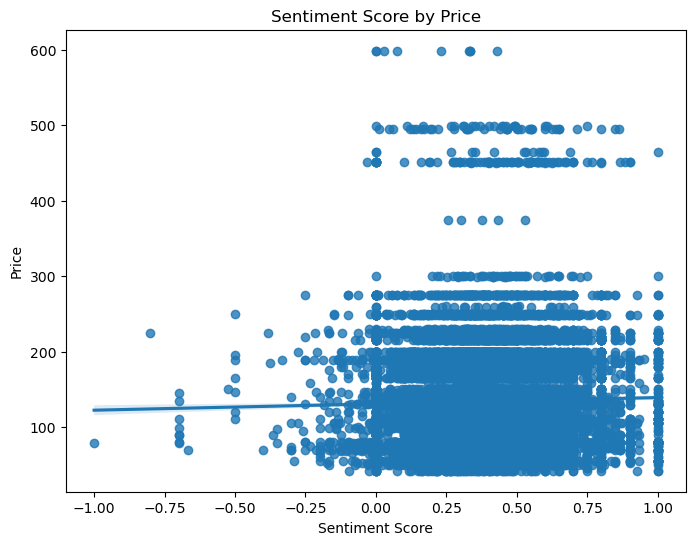

In [49]:
# regression plot of sentiment score by price
plt.figure(figsize=(8, 6))
sns.regplot(x='sentiment_score', y='price', data=airbnb)
plt.xlabel('Sentiment Score')
plt.ylabel('Price')
plt.title('Sentiment Score by Price')
plt.show()

From the linear regression plot, there seems to be a relation between price and sentiment score, but not obvious.

We can segment sentiment scores into 4 groups and look at if different groups have different price distribution. 
* -1.00 to -0.50: very unsatisfied
* -0.50 to 0.00: slightly unsatisfied
* 0.00 to 0.50: slightly satisfied
* 0.50 to 1.00: very satisfied

In [50]:
# segment sentiment score into 4 groups
airbnb['sentiment_score_group'] = \
    pd.cut(airbnb['sentiment_score'], bins=4, 
                labels=['very unsatisfied', 'slightly unsatisfied',
                         'slightly satisfied', 'very satisfied'])
airbnb['sentiment_score_group'].value_counts()

sentiment_score_group
slightly satisfied      10521
very satisfied           3952
slightly unsatisfied     1481
very unsatisfied           19
Name: count, dtype: int64

/Users/dqq/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/dqq/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


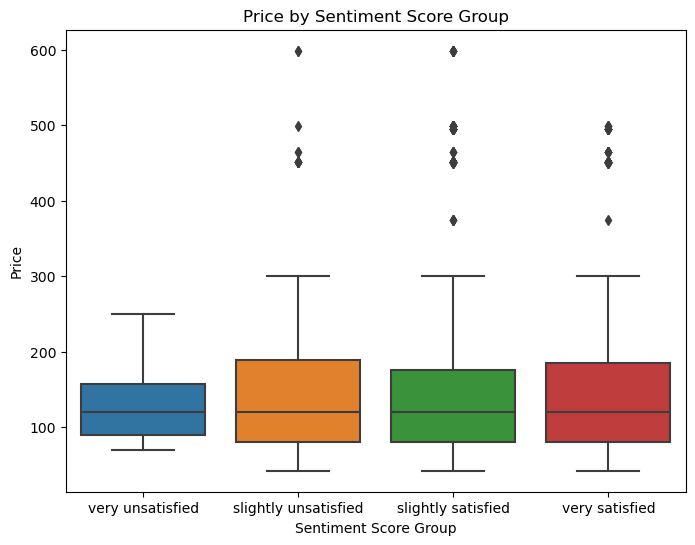

In [51]:
# box plot of price by sentiment score group
plt.figure(figsize=(8, 6))
sns.boxplot(x='sentiment_score_group', y='price', data=airbnb[airbnb.price < 2000])
plt.xlabel('Sentiment Score Group')
plt.ylabel('Price')
plt.title('Price by Sentiment Score Group')
plt.show()

In [52]:
# anova test
import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols

formula = 'price ~ C(sentiment_score_group)'
lm = ols(formula, airbnb).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                                sum_sq       df         F    PR(>F)
C(sentiment_score_group)  1.295097e+05      3.0  9.332998  0.000004
Residual                  7.386478e+07  15969.0       NaN       NaN


From the result of the ANOVA test, there exist differences of prices across different sentiment scores. This means there is a relation between price and sentiment scores. More expensive rooms tend to have more good reviews. Cheaper ones have more bad reviews.

#### Price Trend over Time

In [53]:
# sentiment score over time
year_sentiment = airbnb.groupby(airbnb['review_posted_date'].dt.year)['sentiment_score'].mean()
year_sentiment

review_posted_date
2009    0.391565
2010    0.380902
2011    0.386914
2012    0.367699
2013    0.361969
2014    0.349625
2015    0.349466
2016    0.357285
2017    0.369377
2018    0.389514
2019    0.384713
2020    0.424172
2021    0.420884
2022    0.446848
Name: sentiment_score, dtype: float64

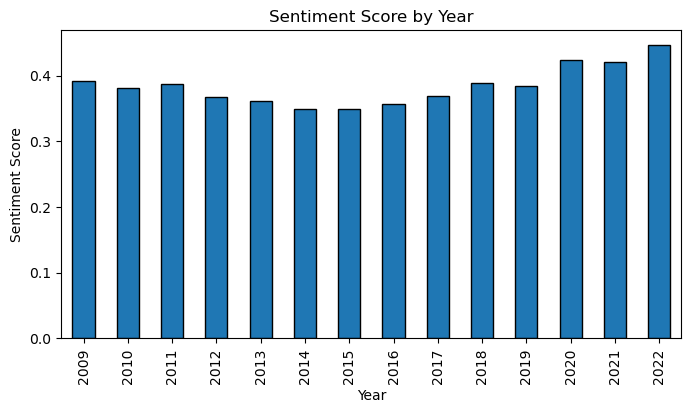

In [54]:
# plot sentiment score over time
plt.figure(figsize=(8, 4))
year_sentiment.plot(kind='bar', edgecolor='black')
plt.xlabel('Year')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Score by Year')
plt.show()

We also want to look at the sentiment score over time. To simplify the analysis, we use the mean value of sentiment score over one year, which can reveal the satisfactory level. From the plot above, we can see the satisfactory level first decreased from 2011 to 2015, then started to increase in general. with a slight decrease in 2019.

### Evaluation
Evaluate the relationship between the relative price and satisfactory
(Relative price = Actual Price - Predicted Price (Expected Price)).

In [55]:
price_differences_lr = y_pred - y_test
price_differences_lr.value_counts()

price
-58.553079    22
 51.446921    17
-94.553079    16
 50.446921    16
 61.446921    15
              ..
 55.663623     1
-17.001247     1
 22.720944     1
-15.581312     1
 44.126973     1
Name: count, Length: 2672, dtype: int64

In [56]:
price_differences_rf = y_pred_rf - y_test
price_differences_rf.value_counts()

price
 0.00     3156
 2.80        5
-2.00        4
-1.05        4
 0.95        3
 1.10        3
-0.70        3
 0.39        3
 0.65        2
-0.75        2
 83.47       1
 0.88        1
 2.50        1
-0.43        1
 0.91        1
-0.10        1
-1.10        1
-0.49        1
-1.75        1
-8.36        1
Name: count, dtype: int64

In [57]:
test_indices = X_test.index
test_set = airbnb.loc[test_indices]
test_set['price_differences_rf'] = price_differences_rf
test_set['price_differences_lr'] = price_differences_lr
test_set = test_set[abs(test_set.price_differences_rf) < 50]
test_set

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,reviews_per_month,calculated_host_listings_count,availability_365,listing_id,review_posted_date,review,sentiment_score,sentiment_score_group,price_differences_rf,price_differences_lr
1766,12192,ENJOY Downtown NYC!,46978,Edward,2,13,40.72290,-73.98199,1,68,...,2.08,2,96,12192,2019-08-01,Amazing location and fantastic hospitality. I’...,0.467440,slightly satisfied,0.0,66.864801
6927,126443,☆Massive DUPLEX☆ 2BR & 2BTH East Village 9+ Gu...,627217,Seith,2,13,40.72939,-73.98857,0,189,...,4.10,3,201,126443,2016-11-01,Thank you!,0.000000,slightly unsatisfied,0.0,-58.553079
14972,1217318,Williamsburg Penthouse Hideaway,6642777,Martin,1,48,40.71024,-73.95170,1,105,...,5.06,2,69,1217318,2017-04-01,Apartment was in a great Williamsburg location.,0.800000,very satisfied,0.0,33.007904
6291,115535,Sun-Drenched Hamilton Hts Jewel,567187,Jane,2,23,40.82399,-73.95328,1,65,...,0.35,1,283,115535,2017-11-01,"I loved the place, it was clean, I felt at hom...",0.600000,very satisfied,0.0,71.117659
14413,1185525,Peaceful Brooklyn Flat,6483295,Jason,1,1,40.63719,-74.03489,0,80,...,0.53,1,192,1185525,2018-09-01,Jason is a great host. The apartment is cozy a...,0.443056,slightly satisfied,0.0,54.634341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3894,16595,*HAVEN LOFT - Entire Floor - Six Windows - Bri...,64522,Daniel,1,48,40.70933,-73.96792,0,275,...,1.40,1,362,16595,2011-05-01,Daniel's pad is a well-polished gem buried bey...,0.289524,slightly satisfied,0.0,-141.816723
15507,1847389,Beautiful BK 1 Block From Subway,9371210,Shane,1,6,40.67522,-73.99978,0,180,...,0.63,1,45,1847389,2021-08-01,Our host was excellent.. the accommodations ve...,0.000000,slightly unsatisfied,-0.7,-49.553079
11628,227715,ROOM WITH KITCHENETTE #2,209460,Marylyn,1,2,40.67855,-73.94949,0,80,...,2.47,4,308,227715,2012-05-01,De studio was precies zoals in de advertentie ...,0.000000,slightly unsatisfied,0.0,50.446921
221,5178,Large Furnished Room Near B'way,8967,Shunichi,2,24,40.76489,-73.98493,1,79,...,3.47,1,220,5178,2013-12-01,If u are fine with older spaces with character...,0.261111,slightly satisfied,0.0,53.914742


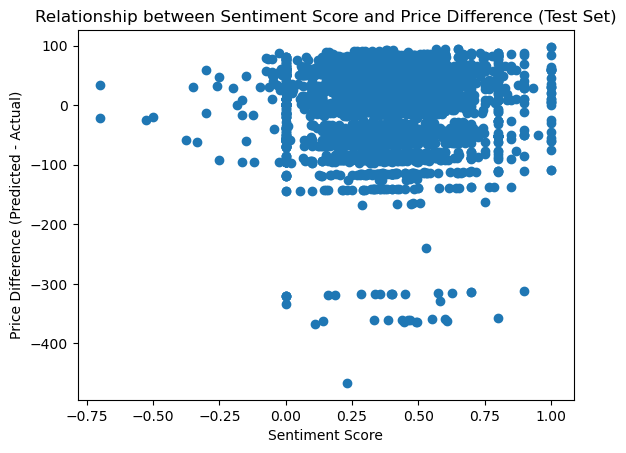

In [58]:
plt.scatter(test_set['sentiment_score'], test_set['price_differences_lr'])
plt.title('Relationship between Sentiment Score and Price Difference (Test Set)')
plt.xlabel('Sentiment Score')
plt.ylabel('Price Difference (Predicted - Actual)')
plt.show()

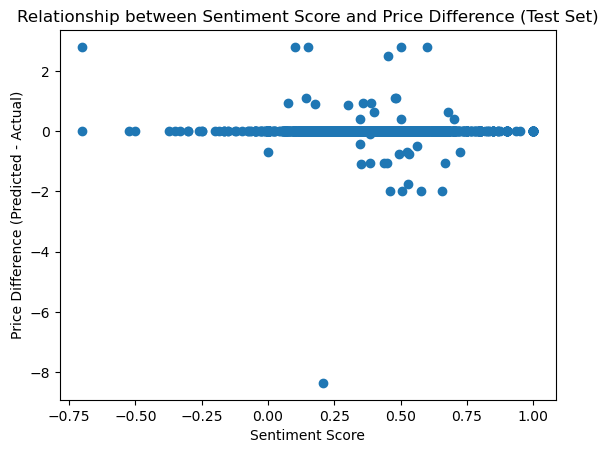

In [59]:
plt.scatter(test_set['sentiment_score'], test_set['price_differences_rf'])
plt.title('Relationship between Sentiment Score and Price Difference (Test Set)')
plt.xlabel('Sentiment Score')
plt.ylabel('Price Difference (Predicted - Actual)')
plt.show()

In [60]:
correlation = test_set['price_differences_lr'].corr(test_set['sentiment_score'])
correlation 

0.01754565521686221

It is found that the price_differences do not have strong correlation with the satisfactory levels of reviewers.

Thus, whether the price is lower or higher than expection will not be a major factor affecting reviewers' satisfactory.

Therefore, we are curious what factors do affect reviewers' satisfactory levels a lot.

### Machine Learning (Predict Users' Satisfactory Levels)

In [61]:
le = LabelEncoder()
airbnb['neighbourhood_group'] = le.fit_transform(airbnb['neighbourhood_group'])
airbnb['neighbourhood'] = le.fit_transform(airbnb['neighbourhood'])
airbnb['room_type'] = le.fit_transform(airbnb['room_type'])

X = airbnb[['neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'minimum_nights',
            'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'price']]
y = airbnb['sentiment_score']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [62]:
LinearRegre = LinearRegression()

LinearRegre.fit(X_train, y_train)

y_pred = LinearRegre.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

r2 = r2_score(y_test, y_pred)
print(f'R-squared (R2): {r2}')

reletive_error = mae/(airbnb.sentiment_score.max() - airbnb.sentiment_score.min())
print(f'reletive error: {reletive_error}')

Mean Absolute Error: 0.16606259443768037
Mean Squared Error: 0.04767743886974969
R-squared (R2): 0.0029768366026942106
reletive error: 0.08303129721884019


In [63]:
coefficients_lr = LinearRegre.coef_
feature_names = ['neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'minimum_nights',
            'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'price']
feature_correlation_lr = pd.DataFrame({'Feature_names': feature_names, 'Coefficients': coefficients_lr})
feature_correlation_lr

,Feature_names,Coefficients
0,neighbourhood_group,-0.009359
1,neighbourhood,0.000230
2,latitude,-0.130778
3,longitude,-0.100512
4,room_type,0.028740
5,minimum_nights,-0.000240
6,number_of_reviews,-0.000094
7,reviews_per_month,0.014506
8,calculated_host_listings_count,-0.006016
9,availability_365,-0.000027


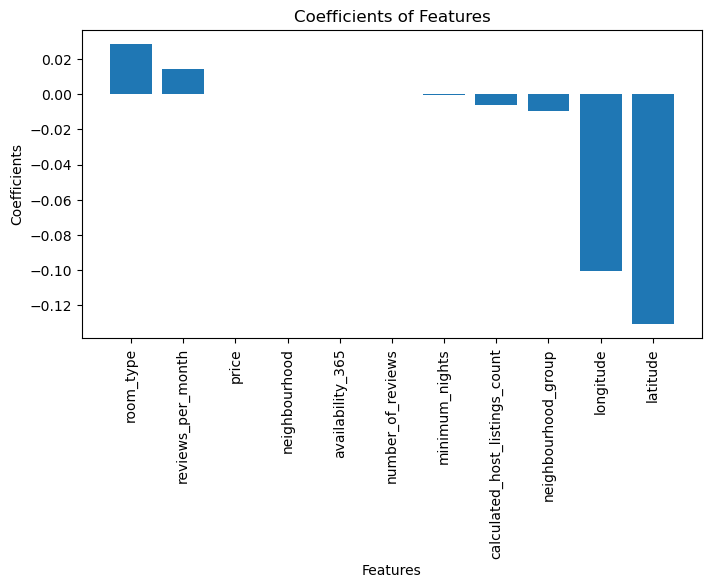

In [64]:
feature_correlation_lr_sorted = \
    feature_correlation_lr \
        .sort_values(by='Coefficients', ascending=False)

#plot the coefficients
plt.figure(figsize=(8, 4))
plt.bar(feature_correlation_lr_sorted['Feature_names'], 
        feature_correlation_lr_sorted['Coefficients'])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Coefficients')
plt.title('Coefficients of Features')
plt.show()

From the results, we can see that neighbourhood, minimum nights, numberof reviews, availability_365 and price do not affect the satisfactory level much.

However, the location of the room and the reviews_per_month strongly affect the satisfactory levels of reviewers.

In [65]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_rf)
print(f'Mean Absolute Error: {mae}')

mse = mean_squared_error(y_test, y_pred_rf)
print(f'Mean Squared Error: {mse}')

r2 = r2_score(y_test, y_pred_rf)
print(f'R-squared (R2): {r2}')

reletive_error = mae/(airbnb.sentiment_score.max() - airbnb.sentiment_score.min())
print(f'reletive error: {reletive_error}')

Mean Absolute Error: 0.1669374056010493
Mean Squared Error: 0.04724264637762329
R-squared (R2): 0.012069149365247167
reletive error: 0.08346870280052465


From the learning score, we can see that R-squared is not very high and the reletive error is not low enough.

Thus, the satisfactory level is not easy to predict and many factors other than the solid data may affect it.

In [66]:
feature_importances = rf_model.feature_importances_
feature_importances 

array([0.00924436, 0.10699569, 0.15607472, 0.12723075, 0.00998452,
       0.10563823, 0.08223054, 0.13636771, 0.04738862, 0.1058774 ,
       0.11296745])

In [67]:
feature_correlation_rf = pd.DataFrame({'Feature_names': feature_names, 'Coefficients': feature_importances})
feature_correlation_rf

,Feature_names,Coefficients
0,neighbourhood_group,0.009244
1,neighbourhood,0.106996
2,latitude,0.156075
3,longitude,0.127231
4,room_type,0.009985
5,minimum_nights,0.105638
6,number_of_reviews,0.082231
7,reviews_per_month,0.136368
8,calculated_host_listings_count,0.047389
9,availability_365,0.105877


In [ ]:
feature_correlation_rf_sorted = feature_correlation_rf.sort_values(by='Coefficients', ascending=False)

#plot the coefficients
plt.figure(figsize=(8, 4))
plt.bar(feature_correlation_rf_sorted['Feature_names'], 
        feature_correlation_rf_sorted['Coefficients'])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Coefficients Importance')
plt.title('Coefficients of Features')
plt.show()

From the results, we can see that neighbourhood_group, room_type, calulated host listings count do not affect the satisfactory level much.

However, the location of the room and the reviews_per_month still strongly affect the satisfactory levels of reviewers.